# Imports & helpers

In [ ]:
%pip install -U "numpy<2" "scipy<1.13" "scikit-learn<1.4" "hmmlearn<0.4" pandas matplotlib ipykernel

import numpy, scipy, sklearn
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("sklearn:", sklearn.__version__)

import IPython
IPython.get_ipython().kernel.do_shutdown(restart=True)


  Using cached hmmlearn-0.3.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (3.0 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 29.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 28.1 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 10.8 MB/s  0:00:00eta 0:00:01
Using cached hmmlearn-0.3.3-cp310-cp310-macosx_10_9_x86_64.whl (130 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.2 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.1 MB/s  0:00:00 eta 0:00:01
Using cached contourpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.w

In [1]:
# Core
import numpy as np
import pandas as pd

# Modeling
from hmmlearn.hmm import GaussianHMM

# Plotting
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)

# ---- Helper metrics ----
def sharpe_ratio(returns, freq=252, eps=1e-12):
    """Annualized Sharpe from daily returns."""
    mu = returns.mean() * freq
    sd = returns.std(ddof=0) * np.sqrt(freq)
    return mu / (sd + eps)

def max_drawdown(cum_curve):
    """Max drawdown from cumulative return curve (array-like)."""
    cum = np.asarray(cum_curve)
    peak = np.maximum.accumulate(cum)
    dd = (cum - peak) / peak
    return dd.min()

def plot_curves(curves_dict, title="Cumulative Returns"):
    plt.figure(figsize=(10,5))
    for name, series in curves_dict.items():
        plt.plot(series.index, series.values, label=name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# data 

In [17]:
# --- DATA: load multiple CSVs from data/ and build log returns ---
import os, glob
import numpy as np
import pandas as pd

USE_SYNTHETIC = False  # now using real files

def pick_price_column(df):
    for c in ["Adj Close", "AdjClose", "Close", "close", "Price", "Adj_Close"]:
        if c in df.columns:
            return c
    # fallback: last numeric column
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        raise ValueError("No numeric price column found.")
    return num_cols[-1]

def load_prices_folder(folder="data"):
    series = []
    files = sorted(glob.glob(os.path.join(folder, "*.csv")))
    if not files:
        raise FileNotFoundError("No CSV files found in 'data/'.")
    for f in files:
        tkr = os.path.splitext(os.path.basename(f))[0]
        df = pd.read_csv(f)
        # parse date
        date_col = "Date" if "Date" in df.columns else df.columns[0]
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.set_index(date_col).sort_index()
        col = pick_price_column(df)
        s = df[col].astype(float).rename(tkr)
        series.append(s)
    px = pd.concat(series, axis=1).dropna(how="any")  # common dates
    px = px[~px.index.duplicated(keep="first")]
    return px

prices = load_prices_folder("data")
prices = prices.asfreq("B").fillna(method="ffill")  # align to business days
print("Assets:", list(prices.columns))
display(prices.tail())

# log returns
returns = np.log(prices).diff().dropna()
display(returns.tail())


Assets: ['BIL', 'GLD', 'IEF', 'TSLA', '_GSPC']


/var/folders/vw/zzmp8l0n22dfgqwqwtcs06340000gn/T/ipykernel_8934/360956707.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.asfreq("B").fillna(method="ffill")  # align to business days


,BIL,GLD,IEF,TSLA,_GSPC
Date,,,,,
2025-10-02,91.47,354.79,96.59,436.00,669.22
2025-10-03,91.49,357.64,96.40,429.83,669.21
2025-10-06,91.51,364.38,96.12,453.25,671.61
2025-10-07,91.51,366.26,96.36,433.09,669.12
2025-10-08,91.53,372.30,96.38,438.69,673.11


,BIL,GLD,IEF,TSLA,_GSPC
Date,,,,,
2025-10-02,0.000109,-0.003489,0.001036,-0.052410,0.001151
2025-10-03,0.000219,0.008001,-0.001969,-0.014252,-0.000015
2025-10-06,0.000219,0.018670,-0.002909,0.053054,0.003580
2025-10-07,0.000000,0.005146,0.002494,-0.045498,-0.003714
2025-10-08,0.000219,0.016357,0.000208,0.012847,0.005945


# HMM selection (BIC) + fit

In [22]:
# --- HMM on 21d rolling log-vol of equal-weight portfolio ---
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd

ew_ret = returns.mean(axis=1)
roll_vol = ew_ret.rolling(21).std().dropna()
vol_signal = np.log(roll_vol.values.reshape(-1, 1) + 1e-12)

# align returns to vol signal index
R_aligned = returns.loc[roll_vol.index]

def fit_hmm_bic(X, k_min=2, k_max=4, random_state=7, max_iter=500):
    best_model, best_bic, best_k = None, np.inf, None
    N = len(X)
    for k in range(k_min, k_max + 1):
        m = GaussianHMM(n_components=k, covariance_type="diag", n_iter=max_iter, random_state=random_state)
        m.fit(X)
        logL = m.score(X)
        p = k + k + k*(k-1) + (k-1)
        bic = -2*logL + p*np.log(N)
        if bic < best_bic:
            best_bic, best_model, best_k = bic, m, k
    return best_k, best_model

best_k, hmm_model = fit_hmm_bic(vol_signal, k_min=2, k_max=4)
print("Selected states (BIC):", best_k)

states_map = hmm_model.predict(vol_signal)
state_series = pd.Series(states_map, index=R_aligned.index, name="state")
state_series.head()


Selected states (BIC): 4


Date
2010-07-27    3
2010-07-28    3
2010-07-29    3
2010-07-30    3
2010-08-02    3
Freq: B, Name: state, dtype: int64

# Regime stats + inverse-vol weights

In [23]:
# --- mean–variance weights per regime ---
import numpy as np
import pandas as pd

def mean_var_weights(returns, lam=5, eps=1e-8):
    mu = returns.mean().values.reshape(-1, 1)
    cov = returns.cov().values
    inv = np.linalg.pinv(cov + eps*np.eye(cov.shape[0]))
    w = inv @ mu
    w = w / np.sum(np.abs(w))                 # normalize exposure
    w = (w * (1 - 1/lam)) + (np.ones_like(w)/len(w)) * (1/lam)  # blend with EW
    return pd.Series(w.ravel(), index=returns.columns)

regime_weights = {}
for s in sorted(state_series.unique()):
    mask = state_series == s
    R_sub = R_aligned[mask] if mask.sum() >= 30 else R_aligned
    regime_weights[s] = mean_var_weights(R_sub, lam=5)

regime_weights = pd.DataFrame(regime_weights).T
regime_weights = regime_weights.clip(-0.5, 0.5)                     # cap exposures
regime_weights = regime_weights.div(regime_weights.abs().sum(axis=1), axis=0)  # normalize
regime_weights.index.name = "state"
display(regime_weights)


,BIL,GLD,IEF,TSLA,_GSPC
state,,,,,
0,0.648281,0.083242,0.117822,0.067668,0.082987
1,0.406718,0.129791,0.251793,0.027280,0.184418
2,0.708757,0.041356,0.084067,0.068847,0.096973
3,0.730345,0.095988,-0.043176,0.066468,0.064022


# Backtest + plot

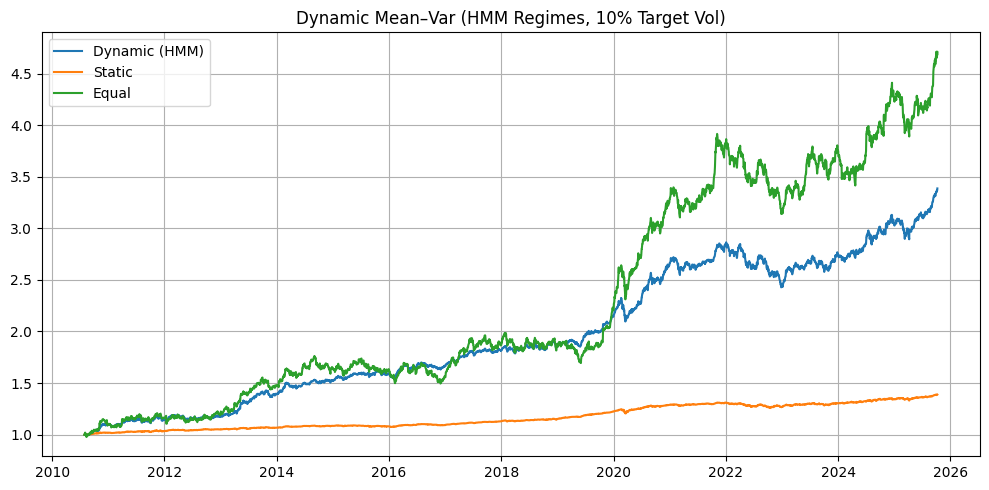

In [24]:
# --- backtest using previous day's regime weights ---
import matplotlib.pyplot as plt

def plot_curves(curves: dict, title="Cumulative Returns"):
    plt.figure(figsize=(10,5))
    for name, series in curves.items():
        plt.plot(series.index, series.values, label=name)
    plt.title(title); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

shifted_states = state_series.shift(1).dropna()
R = R_aligned.loc[shifted_states.index]  # log returns

# Dynamic (HMM)
W_dyn = pd.DataFrame([regime_weights.loc[s] for s in shifted_states.values],
                     index=R.index, columns=R.columns)

# Static mean–var
C_full = R_aligned.cov()
mu_full = R_aligned.mean().values.reshape(-1,1)
inv = np.linalg.pinv(C_full + 1e-8*np.eye(C_full.shape[0]))
w_full = inv @ mu_full
w_full = w_full / np.sum(np.abs(w_full))
W_static = pd.DataFrame([w_full.ravel()]*len(R), index=R.index, columns=R.columns)

# Equal weight
eq = pd.Series(np.ones(R.shape[1])/R.shape[1], index=R.columns)
W_eq = pd.DataFrame([eq]*len(R), index=R.index, columns=R.columns)

# Portfolio daily log returns
ret_dyn    = (W_dyn * R).sum(axis=1)
ret_static = (W_static * R).sum(axis=1)
ret_eq     = (W_eq * R).sum(axis=1)

# Vol targeting (~10% annual)
def vol_target(r, lookback=21, target_ann_vol=0.10, lb=0.5, ub=1.5):
    rv = r.rolling(lookback).std() * np.sqrt(252)
    lev = (target_ann_vol / rv.replace(0, np.nan)).clip(lb, ub).fillna(1.0)
    return (lev.shift(1) * r).dropna()

ret_dyn_t    = vol_target(ret_dyn)
ret_static_t = vol_target(ret_static)
ret_eq_t     = vol_target(ret_eq)

# Cum curves (log-return compounding)
cum_dyn    = np.exp(ret_dyn_t.cumsum())
cum_static = np.exp(ret_static_t.cumsum())
cum_eq     = np.exp(ret_eq_t.cumsum())

plot_curves(
    {"Dynamic (HMM)": cum_dyn, "Static": cum_static, "Equal": cum_eq},
    title="Dynamic Mean–Var (HMM Regimes, 10% Target Vol)"
)


# KPI

In [26]:
import numpy as np
import pandas as pd

def sharpe_ratio(r, freq=252, eps=1e-12):
    mu = r.mean()*freq
    sd = r.std(ddof=0)*np.sqrt(freq)
    return float(mu/(sd+eps))

def max_drawdown(c):
    x = c.values
    peak = np.maximum.accumulate(x)
    dd = (x-peak)/peak
    return float(dd.min())

summary = pd.DataFrame({
    "Ann. Sharpe": [sharpe_ratio(ret_dyn_t), sharpe_ratio(ret_static_t), sharpe_ratio(ret_eq_t)],
    "Max Drawdown": [max_drawdown(cum_dyn), max_drawdown(cum_static), max_drawdown(cum_eq)],
    "Ann. Return": [ret_dyn_t.mean()*252, ret_static_t.mean()*252, ret_eq_t.mean()*252],
    "Ann. Vol": [ret_dyn_t.std(ddof=0)*np.sqrt(252),
                 ret_static_t.std(ddof=0)*np.sqrt(252),
                 ret_eq_t.std(ddof=0)*np.sqrt(252)],
}, index=["Dynamic (HMM)", "Static", "Equal"]).round(4)

summary


,Ann. Sharpe,Max Drawdown,Ann. Return,Ann. Vol
Dynamic (HMM),1.1496,-0.1523,0.0775,0.0674
Static,1.1083,-0.0388,0.0208,0.0188
Equal,0.8666,-0.1979,0.0984,0.1136


# Rolling config

In [34]:
# Rolling params
ROLL_WINDOW = 504      # ~2 years
ROLL_STEP   = 21       # refit monthly
MIN_REG_OBS = 60       # min obs for regime subset
LAM_MV      = 5        # risk aversion for mean–var

def vol_target(r, lookback=21, target_ann_vol=0.10, lb=0.5, ub=1.5):
    rv = r.rolling(lookback).std() * np.sqrt(252)
    lev = (target_ann_vol / rv.replace(0, np.nan)).clip(lb, ub).fillna(1.0)
    return (lev.shift(1) * r).dropna()


# Rolling backtest & plot

In [35]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd

def fit_hmm_bic(X, k_min=2, k_max=4, random_state=7, max_iter=300):
    best_model, best_bic, best_k = None, np.inf, None
    N = len(X)
    for k in range(k_min, k_max + 1):
        m = GaussianHMM(n_components=k, covariance_type="diag", n_iter=max_iter, random_state=random_state)
        m.fit(X); logL = m.score(X)
        p = k + k + k*(k-1) + (k-1)
        bic = -2*logL + p*np.log(N)
        if bic < best_bic:
            best_bic, best_model, best_k = bic, m, k
    return best_k, best_model

def mean_var_weights(returns, lam=5, eps=1e-8):
    mu  = returns.mean().values.reshape(-1, 1)
    cov = returns.cov().values
    inv = np.linalg.pinv(cov + eps*np.eye(cov.shape[0]))
    w   = inv @ mu
    w   = w / np.sum(np.abs(w))
    w   = (w * (1 - 1/lam)) + (np.ones_like(w)/len(w))*(1/lam)
    return pd.Series(w.ravel(), index=returns.columns)

def rolling_hmm_weights(returns: pd.DataFrame,
                        window=504, step=21, min_reg_obs=60, lam=5):
    idx = returns.index
    if len(idx) <= window + step:
        raise ValueError(f"Not enough data for rolling window={window}. Reduce ROLL_WINDOW.")

    ew = returns.mean(axis=1)  # EW log returns
    W_chunks = []

    # iterate refit points
    for t in range(window, len(idx), step):
        past_ret = returns.iloc[t-window:t]              # past window only
        rv = ew.iloc[:t].rolling(21).std().dropna()      # past vol proxy
        if len(rv) < window:
            continue
        sig_win = np.log(rv.iloc[-window:].values.reshape(-1,1) + 1e-12)

        # fit HMM on past window
        k, m = fit_hmm_bic(sig_win, 2, 4)
        st_hist = m.predict(sig_win)
        st_now  = st_hist[-1]

        # regime subset from past window
        mask = (st_hist == st_now)
        if mask.sum() >= min_reg_obs:
            # map mask (window-length) to past_ret rows
            R_sub = past_ret.iloc[np.where(mask)[0]]
        else:
            R_sub = past_ret

        # weights for next period
        w_now = mean_var_weights(R_sub, lam=lam).clip(-0.5, 0.5)
        w_now = w_now / w_now.abs().sum()

        # fill until next refit or end
        end_i = min(t + step, len(idx))
        fill_idx = idx[t:end_i]
        if len(fill_idx) == 0:
            continue
        W_chunks.append(pd.DataFrame([w_now.values]*len(fill_idx),
                                     index=fill_idx, columns=returns.columns))

    if not W_chunks:
        raise RuntimeError("Rolling procedure produced no weights. Try smaller ROLL_WINDOW or step.")

    W_roll = pd.concat(W_chunks).sort_index()
    W_roll = W_roll.loc[~W_roll.index.duplicated(keep="first")]
    return W_roll

# ---- build rolling weights ----
W_dyn_roll = rolling_hmm_weights(
    returns,
    window=ROLL_WINDOW,
    step=ROLL_STEP,
    min_reg_obs=MIN_REG_OBS,
    lam=LAM_MV
)

print("W_dyn_roll shape:", W_dyn_roll.shape, "| start:", W_dyn_roll.index.min(), "| end:", W_dyn_roll.index.max())
display(W_dyn_roll.tail())


Model is not converging.  Current: 332.25072550316605 is not greater than 332.25094124823653. Delta is -0.00021574507047716907
Model is not converging.  Current: 382.04177847587164 is not greater than 382.0446548182332. Delta is -0.0028763423615600914
Model is not converging.  Current: 420.81046604776856 is not greater than 420.8122310586645. Delta is -0.001765010895951491
Model is not converging.  Current: 402.84672558199145 is not greater than 402.84830136404486. Delta is -0.0015757820534076927
Model is not converging.  Current: 205.38808440842683 is not greater than 205.38955811263332. Delta is -0.0014737042064894013
Model is not converging.  Current: 533.7630365784335 is not greater than 533.7665937681525. Delta is -0.0035571897190038726
Model is not converging.  Current: 453.27142890577755 is not greater than 453.2726555854756. Delta is -0.001226679698049793
Model is not converging.  Current: 479.9184818981356 is not greater than 479.9216283536003. Delta is -0.0031464554646731813


W_dyn_roll shape: (3462, 5) | start: 2012-07-03 00:00:00 | end: 2025-10-08 00:00:00


,BIL,GLD,IEF,TSLA,_GSPC
Date,,,,,
2025-10-02,0.485453,0.176196,-0.083962,0.031082,0.223307
2025-10-03,0.485453,0.176196,-0.083962,0.031082,0.223307
2025-10-06,0.485453,0.176196,-0.083962,0.031082,0.223307
2025-10-07,0.485453,0.176196,-0.083962,0.031082,0.223307
2025-10-08,0.485453,0.176196,-0.083962,0.031082,0.223307


# Rolling KPI



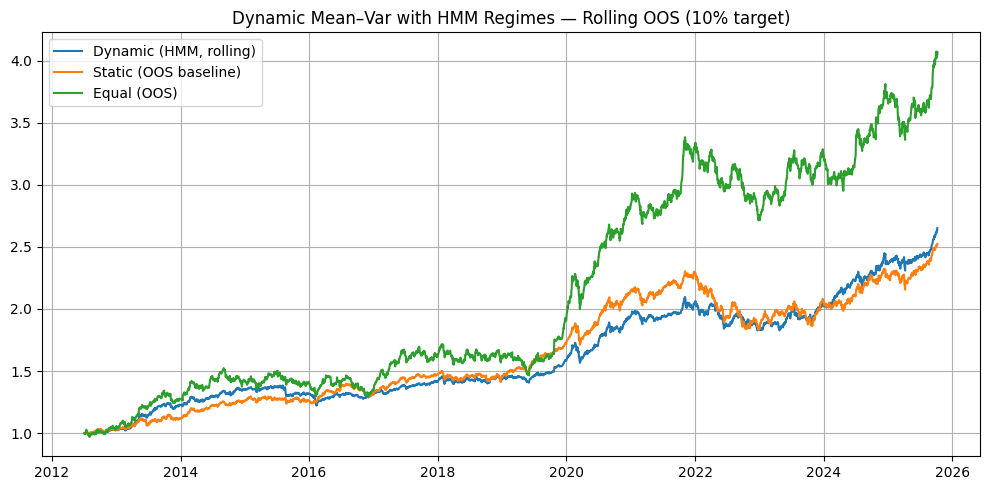

,Ann. Sharpe,Max Drawdown,Ann. Return,Ann. Vol
"Dynamic (HMM, rolling)",1.0467,-0.1292,0.0710,0.0678
Static (OOS baseline),0.8943,-0.2056,0.0674,0.0754
Equal (OOS),0.9100,-0.1979,0.1022,0.1123


In [38]:
# --- Rolling backtest (OOS), plots, and KPIs ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# helpers (lightweight)
def mean_var_weights(returns, lam=5, eps=1e-8):
    mu  = returns.mean().values.reshape(-1, 1)
    cov = returns.cov().values
    inv = np.linalg.pinv(cov + eps*np.eye(cov.shape[0]))
    w   = inv @ mu
    w   = w / np.sum(np.abs(w))
    w   = (w * (1 - 1/lam)) + (np.ones_like(w)/len(w))*(1/lam)
    return pd.Series(w.ravel(), index=returns.columns)

def vol_target(r, lookback=21, target_ann_vol=0.10, lb=0.5, ub=1.5):
    rv = r.rolling(lookback).std() * np.sqrt(252)
    lev = (target_ann_vol / rv.replace(0, np.nan)).clip(lb, ub).fillna(1.0)
    return (lev.shift(1) * r).dropna()

def sharpe_ratio(r, freq=252, eps=1e-12):
    mu = r.mean()*freq
    sd = r.std(ddof=0)*np.sqrt(freq)
    return float(mu/(sd+eps))

def max_drawdown(c):
    x = c.values
    peak = np.maximum.accumulate(x)
    dd = (x-peak)/peak
    return float(dd.min())

def plot_curves(curves: dict, title="Cumulative Returns (Rolling OOS)"):
    plt.figure(figsize=(10,5))
    for name, series in curves.items():
        plt.plot(series.index, series.values, label=name)
    plt.title(title); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 1) align weights and returns
if "W_dyn_roll" not in globals():
    raise RuntimeError("W_dyn_roll not found. Run Cell 10 first.")

common_idx = W_dyn_roll.index.intersection(returns.index)
W_dyn_roll = W_dyn_roll.loc[common_idx]
R_roll     = returns.loc[common_idx]

# 2) dynamic OOS returns (next-day application)
ret_dyn_roll = (W_dyn_roll.shift(1) * R_roll).sum(axis=1).dropna()

# 3) static OOS baseline: fit before start (use last ROLL_WINDOW days if available)
start_ts = ret_dyn_roll.index[0]
start_pos = returns.index.get_loc(start_ts)
win = min(ROLL_WINDOW if "ROLL_WINDOW" in globals() else 504, start_pos)
R_first = returns.iloc[start_pos-win:start_pos] if win > 0 else returns.iloc[:start_pos]
w_static_oos = mean_var_weights(R_first if len(R_first)>10 else returns.iloc[:start_pos], lam=LAM_MV if "LAM_MV" in globals() else 5)
W_static_oos = pd.DataFrame([w_static_oos.values]*len(ret_dyn_roll.index),
                            index=ret_dyn_roll.index, columns=returns.columns)
ret_static_roll = (W_static_oos * returns.loc[ret_dyn_roll.index]).sum(axis=1)

# 4) equal-weight OOS baseline
eq = pd.Series(np.ones(returns.shape[1])/returns.shape[1], index=returns.columns)
W_eq_oos = pd.DataFrame([eq.values]*len(ret_dyn_roll.index),
                        index=ret_dyn_roll.index, columns=returns.columns)
ret_eq_roll = (W_eq_oos * returns.loc[ret_dyn_roll.index]).sum(axis=1)

# 5) vol targeting (same rule for all)
ret_dyn_roll_t    = vol_target(ret_dyn_roll)
ret_static_roll_t = vol_target(ret_static_roll)
ret_eq_roll_t     = vol_target(ret_eq_roll)

# 6) cumulative curves (log returns)
cum_dyn_roll    = np.exp(ret_dyn_roll_t.cumsum())
cum_static_roll = np.exp(ret_static_roll_t.cumsum())
cum_eq_roll     = np.exp(ret_eq_roll_t.cumsum())

plot_curves({
    "Dynamic (HMM, rolling)": cum_dyn_roll,
    "Static (OOS baseline)":  cum_static_roll,
    "Equal (OOS)":            cum_eq_roll,
}, "Dynamic Mean–Var with HMM Regimes — Rolling OOS (10% target)")

# 7) KPIs
summary_roll = pd.DataFrame({
    "Ann. Sharpe": [sharpe_ratio(ret_dyn_roll_t), sharpe_ratio(ret_static_roll_t), sharpe_ratio(ret_eq_roll_t)],
    "Max Drawdown": [max_drawdown(cum_dyn_roll), max_drawdown(cum_static_roll), max_drawdown(cum_eq_roll)],
    "Ann. Return": [ret_dyn_roll_t.mean()*252, ret_static_roll_t.mean()*252, ret_eq_roll_t.mean()*252],
    "Ann. Vol": [ret_dyn_roll_t.std(ddof=0)*np.sqrt(252),
                 ret_static_roll_t.std(ddof=0)*np.sqrt(252),
                 ret_eq_roll_t.std(ddof=0)*np.sqrt(252)],
}, index=["Dynamic (HMM, rolling)", "Static (OOS baseline)", "Equal (OOS)"]).round(4)

display(summary_roll)


In [39]:
ROLL_WINDOW = 504    # ~2y
ROLL_STEP   = 21     # monthly refit
MIN_REG_OBS = 60
LAM_GRID    = [3,5,8]          # mean–var risk aversion
VT_GRID     = [0.08,0.10,0.12] # vol targets
SMOOTH_ALPHA = 0.3             # w_t = α w_now + (1-α) w_{t-1}


In [40]:
import numpy as np, pandas as pd
from sklearn.covariance import LedoitWolf

def cov_lw(X):
    lw = LedoitWolf().fit(X.values)
    return pd.DataFrame(lw.covariance_, index=X.columns, columns=X.columns)

def mean_var_weights(returns, lam=5, eps=1e-8):
    mu  = returns.mean().values.reshape(-1,1)
    C   = cov_lw(returns)
    inv = np.linalg.pinv(C.values + eps*np.eye(C.shape[0]))
    w   = inv @ mu
    w   = w / np.sum(np.abs(w))
    w   = (w * (1 - 1/lam)) + (np.ones_like(w)/len(w))*(1/lam)  # blend with EW
    return pd.Series(w.ravel(), index=returns.columns)

def vol_target(r, lookback=21, target_ann_vol=0.10, lb=0.5, ub=1.5):
    rv = r.rolling(lookback).std() * np.sqrt(252)
    lev = (target_ann_vol / rv.replace(0, np.nan)).clip(lb, ub).fillna(1.0)
    return (lev.shift(1) * r).dropna()
